## datadashboard.ipynb

### Overview

This notebook can be used to visualise the crop type data (i.e., the labelled ground and satellite imagery data) available from Radiant MLHub (https://www.mlhub.earth/), that were downloaded using the [mlhub_datadownload](mlhub_datadownload.ipynb) notebook. In this example we consider the dataset "su_african_crops_ghana".

In the first part, a labelled ground tile is selected and visualised, and then segmented into the individual fields of crops. In the second part, the satellite imagery data available over these fields are then visualised.

It is necessary to define the following dictionaries with both information about the considered dataset (see [mlhub_datadownload](mlhub_datadownload.ipynb)), and the paths to the data directories.

In [1]:
import sys
sys.path.insert(0,'../cropseg/')

datasetinfo = { "datadir":"../data/",
                "metadatadir":"../data/metadata/",
                "dataset":"su_african_crops_ghana",
                "groundcollection":"su_african_crops_ghana_labels",
                "s1collection":"su_african_crops_ghana_source_s1",
                "s2collection":"su_african_crops_ghana_source_s2",
                "groundlabels":"su_african_crops_ghana_labels_id.json",
                "groundmetadata":"su_african_crops_ghana_labels.json",
                "s1metadata":"su_african_crops_ghana_source_s1.json",
                "s2metadata":"su_african_crops_ghana_source_s2.json",
                "groundname":"labels.tif",
                "s1imagename":"source.tif",
                "s2imagename":"source.tif",
                "s2maskname":"cloudmask.tif",
                "groundshape":[64,64],
                "s1shape":[64,64],
                "s2shape":[64,64],
                "extension":"tif"
              }
s1bands = [
            {"band":"vv","idx":0},
            {"band":"vh","idx":1},    
          ]  
s2bands = [
            {"band":"blue","wavelength":490,"idx":0},
            {"band":"green","wavelength":560,"idx":1},
            {"band":"red","wavelength":665,"idx":2},
            {"band":"rded1","wavelength":705,"idx":3},
            {"band":"rded2","wavelength":740,"idx":4},
            {"band":"rded3","wavelength":783,"idx":5},
            {"band":"nir","wavelength":842,"idx":6},
            {"band":"rded4","wavelength":865,"idx":7},
            {"band":"swir1","wavelength":1610,"idx":8},
            {"band":"swir2","wavelength":2190,"idx":9}
          ]
s1indices = ["vhvv"]
s2indices = ["ndvi","rdedci","ndmi"]

from mlhubdata import loadjson
groundlabels = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundlabels"]}')
groundmetadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundmetadata"]}')
s1metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s1metadata"]}')
s2metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s2metadata"]}')

### Part 1: The labelled ground data

The ground data comprise N labelled tiles, where the value of each pixel is linked to crop type. The following outputs the various crops types in the considered dataset, and their associated IDs.

In [2]:
for i in range(len(groundlabels)):
    print(groundlabels[i]["id"],groundlabels[i]["crop"])

0 unknown
1 ground nut
2 maize
3 rice
4 soya bean
5 yam
6 intercrop
7 sorghum
8 okra
9 cassava
10 millet
11 tomato
12 cowpea
13 sweet potato
14 babala beans
15 salad vegetables
16 bra and ayoyo
17 watermelon
18 zabla
19 nili
20 kpalika
21 cotton
22 akata
23 nyenabe
24 pepper


Selection of the particular labelled ground tile will likely be driven by the crop of interest. For a given crop (e.g., here 2 - maize), the following will output both the total number of tiles and pixels containing maize across the full dataset, and a distribution of the percentage of pixels per tile containing maize. Finally, the ID of the 10 tiles most populated by maize are output.

Number of ground tiles containing maize: 1873
Total number of pixels containing maize: 322767
Distribution:


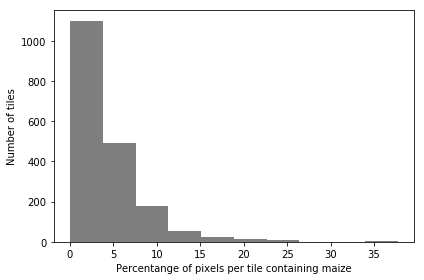

The following tiles are most populated by maize (ID, #pixels):
001783 1545
002441 1424
002470 1367
003186 1151
000433 1073
003820 1068
000337 1058
003871 1035
001999 1024
001165 1017


In [4]:
#####
croptype = 2
#####

import numpy
import matplotlib.pyplot

from grounddata import tilecropcount

cropcount = tilecropcount(datasetinfo,groundlabels,groundmetadata)
filteredcropcount = cropcount[cropcount[:,croptype]>0][cropcount[cropcount[:,croptype]>0][:,croptype].argsort()][::-1]

print(f'Number of ground tiles containing {groundlabels[croptype]["crop"]}:',len(filteredcropcount))
print(f'Total number of pixels containing {groundlabels[croptype]["crop"]}:',numpy.sum(filteredcropcount[:,croptype]))
print(f'Distribution:')
fix,ax = matplotlib.pyplot.subplots()
ax.hist(filteredcropcount[:,croptype]/(numpy.sum(numpy.sum(filteredcropcount,axis=0)[0:len(groundlabels)]) / len(filteredcropcount))*100,color='black',alpha=0.5)
ax.set_xlabel(f'Percentange of pixels per tile containing {groundlabels[croptype]["crop"]}')
ax.set_ylabel('Number of tiles')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()
print(f'The following tiles are most populated by {groundlabels[croptype]["crop"]} (ID, #pixels):')
for i in range(0,10):
    print(str(filteredcropcount[i][len(groundlabels)]).rjust(6,'0'),filteredcropcount[i][croptype])

After selecting a particular labelled ground tile (e.g., "000707"), the following can then be used to view the tile.

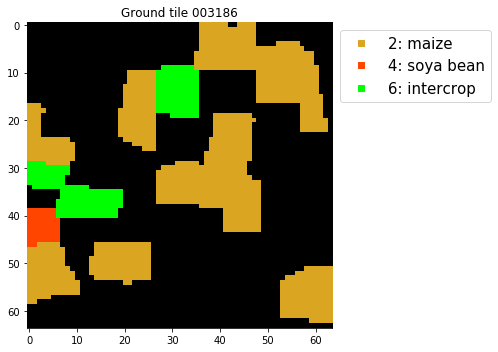

In [5]:
#####
tileid = "003186"
#####

from osgeo import gdal
from PIL import ImageColor

tilehandle = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{datasetinfo["groundcollection"]}_{tileid}/{datasetinfo["groundname"]}')
tiledata = numpy.array(tilehandle.GetRasterBand(1).ReadAsArray(),dtype="int")
crops = numpy.unique(tiledata[tiledata != 0])

fig,ax = matplotlib.pyplot.subplots(figsize=[10,5])
rgb = numpy.zeros([numpy.shape(tiledata)[0],numpy.shape(tiledata)[1],3],dtype=numpy.uint8)
for i in range(len(crops)):
    ax.plot(0,0,"s",color=groundlabels[crops[i]]["colour"],label=f'{groundlabels[crops[i]]["id"]}: {groundlabels[crops[i]]["crop"]}',zorder=0)
    colour = ImageColor.getcolor(groundlabels[crops[i]]["colour"],"RGB")
    rgb[tiledata == crops[i],0] = colour[0]
    rgb[tiledata == crops[i],1] = colour[1]
    rgb[tiledata == crops[i],2] = colour[2]
ax.imshow(rgb,interpolation=None,aspect="equal",zorder=5)
ax.set_title(f'Ground tile {tileid}')
ax.legend(bbox_to_anchor=(1.0,1.0),loc="upper left",fontsize=15)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

The next step is to segment this labelled ground tile into the individual fields of crops. The variable "fieldmasks" provides masks for each field, which are accessible via the field IDs plotted below. At this stage it is also possible to erode the individual fields (via mathematical morphology), which might be useful in preventing edge effects from influencing the signal in the satellite imagery data.

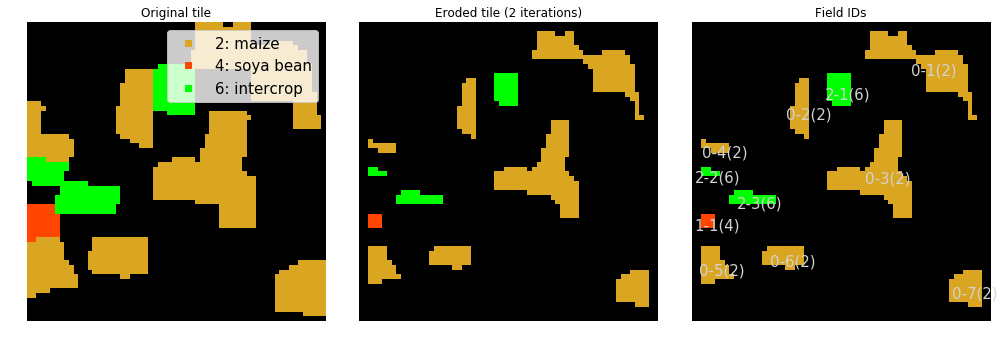

In [6]:
#####
erosioniterations = 2
#####

import scipy.ndimage
from grounddata import erodedfieldmasks

fieldmasks = erodedfieldmasks(tiledata,erosioniterations)

fig,ax = matplotlib.pyplot.subplots(1,3,figsize=[14,5])
axs = ax.ravel()
rgb = numpy.zeros([numpy.shape(tiledata)[0],numpy.shape(tiledata)[1],3],dtype=numpy.uint8)  
for i in range(len(fieldmasks)):
    colour = ImageColor.getcolor(groundlabels[crops[i]]["colour"],"RGB")
    for j in range(1,fieldmasks[i][1]+1):
        com = scipy.ndimage.center_of_mass(fieldmasks[i][0] == j)
        axs[2].text(com[1]-3,com[0]+2,s=f'{i}-{j}({groundlabels[crops[i]]["id"]})',color="lightgrey",size=15,zorder=10)
        rgb[fieldmasks[i][0] == j,0] = colour[0]
        rgb[fieldmasks[i][0] == j,1] = colour[1]
        rgb[fieldmasks[i][0] == j,2] = colour[2]
axs[1].imshow(rgb,interpolation=None,aspect="equal",zorder=5)
axs[2].imshow(rgb,interpolation=None,aspect="equal",zorder=5)       
for i in range(len(crops)):
    axs[0].plot(0,0,"s",color=groundlabels[crops[i]]["colour"],label=f'{groundlabels[crops[i]]["id"]}: {groundlabels[crops[i]]["crop"]}',zorder=0)
    colour = ImageColor.getcolor(groundlabels[crops[i]]["colour"],"RGB")
    rgb[tiledata == crops[i],0] = colour[0]
    rgb[tiledata == crops[i],1] = colour[1]
    rgb[tiledata == crops[i],2] = colour[2]
axs[0].legend(bbox_to_anchor=(1.0,1.0),loc="best",fontsize=15)
axs[0].imshow(rgb,interpolation=None,aspect="equal",zorder=5)    
axs[0].set_title("Original tile")      
axs[1].set_title(f'Eroded tile ({erosioniterations} iterations)')
axs[2].set_title("Field IDs")
axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

### Part 2: The satellite imagery data

The second part of this notebook is used to visualise the satellite imagery data available over these fields. If the collections of satellite imagery were not downloaded by [mlhub_datadownload](mlhub_datadownload.ipynb), it is necessary to download the Sentinel-1 and Sentinel-2 items available for this particular labelled ground tile. The following checks whether these data already exist in the data directory, and if not, downloads them now. These data are then loaded into numpy arrays.

In [7]:
from mlhubdata import get_tileitems_from_collection
from satellitedata import load_satellite_data_as_array
from satellitedata import load_satellite_cloudmasks_as_array

s1items,s1dates = get_tileitems_from_collection(tileid,s1metadata,datasetinfo,verbose=1)
s2items,s2dates = get_tileitems_from_collection(tileid,s2metadata,datasetinfo,verbose=1)
s1data = load_satellite_data_as_array(s1items,s1bands,s1indices,datasetinfo,datasetinfo["s1shape"])
s2data = load_satellite_data_as_array(s2items,s2bands,s2indices,datasetinfo,datasetinfo["s2shape"],rr=4096.)
s2cloudmasks = load_satellite_cloudmasks_as_array(s2items,datasetinfo,datasetinfo["s2shape"])

Items for 003186 are available                                                                                                    
Items for 003186 are available                                                                                                    


It is useful to first view a timeline of the availability of Sentinel-1 and Sentinel-2 observations over the labelled ground tile.

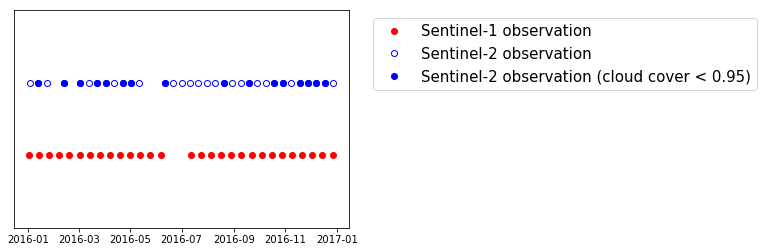

In [8]:
#####
cloudcover_max = 0.95
#####

from satellitedata import cloudfreeitems

s2cfitems,s2cfdates = cloudfreeitems(s2items,s2cloudmasks,cloudcover_max)

fig, ax = matplotlib.pyplot.subplots()
ax.plot(s1dates,numpy.zeros_like(s1dates),"o",color="red",label='Sentinel-1 observation')
ax.plot(s2dates,numpy.zeros_like(s2dates)+1,"o",color="blue",fillstyle='none',label=f'Sentinel-2 observation')
ax.plot(s2cfdates,numpy.zeros_like(s2cfdates)+1,"o",color="blue",label=f'Sentinel-2 observation (cloud cover < {cloudcover_max})')
ax.set_ylim([-1,2])
ax.set(yticklabels=[])
ax.tick_params(left=False)
ax.legend(bbox_to_anchor=(1.05,1.0),loc='upper left',fontsize=15)
matplotlib.pyplot.show()

It might also be useful to view a sequence of RGB composites from the clear(ish) Sentinel-2 observations across this timeline.

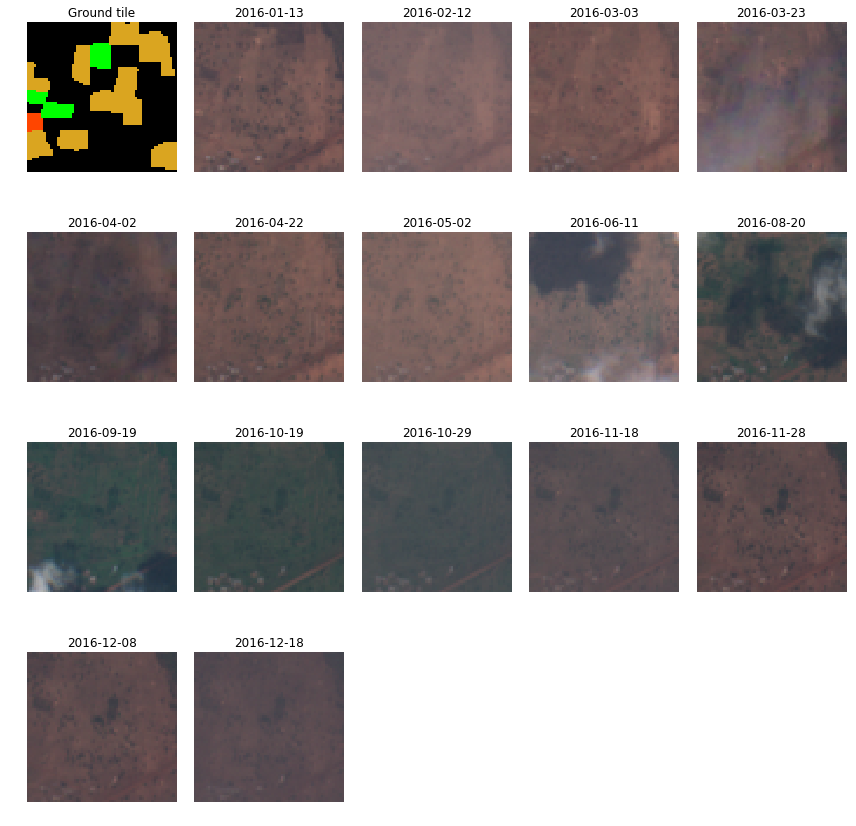

In [9]:
import math
from plotting import rgbcomposite

images = len(s2cfitems) + 1
ncols = 5
nrows = math.ceil(images/ncols)
fig, axs = matplotlib.pyplot.subplots(nrows,ncols,figsize=[12,12],sharex="all",sharey="all")
axs = axs.ravel()
rgb = numpy.zeros([numpy.shape(tiledata)[0],numpy.shape(tiledata)[1],3],dtype=numpy.uint8)
for i in range(len(crops)):
    colour = ImageColor.getcolor(groundlabels[crops[i]]["colour"],"RGB")
    rgb[tiledata == crops[i],0] = colour[0]
    rgb[tiledata == crops[i],1] = colour[1]
    rgb[tiledata == crops[i],2] = colour[2]
axs[0].imshow(rgb,interpolation=None,aspect="equal")
axs[0].set_title("Ground tile")
axs[0].axis("off")
idx = 1
for i in range(len(s2items)):
    if (s2dates[i] in s2cfdates) == True:
        rgb = rgbcomposite(s2data[i],s2bands)
        axs[idx].imshow(rgb,interpolation=None,aspect="equal")
        axs[idx].set_title(s2dates[i])
        axs[idx].axis("off")
        idx = idx + 1
for i in range(0,ncols*nrows):
    if i >= images:
        fig.delaxes(axs[i])
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

Next, the following visualises the Sentinel-1 VHVV ratio for each field, as a function of time.

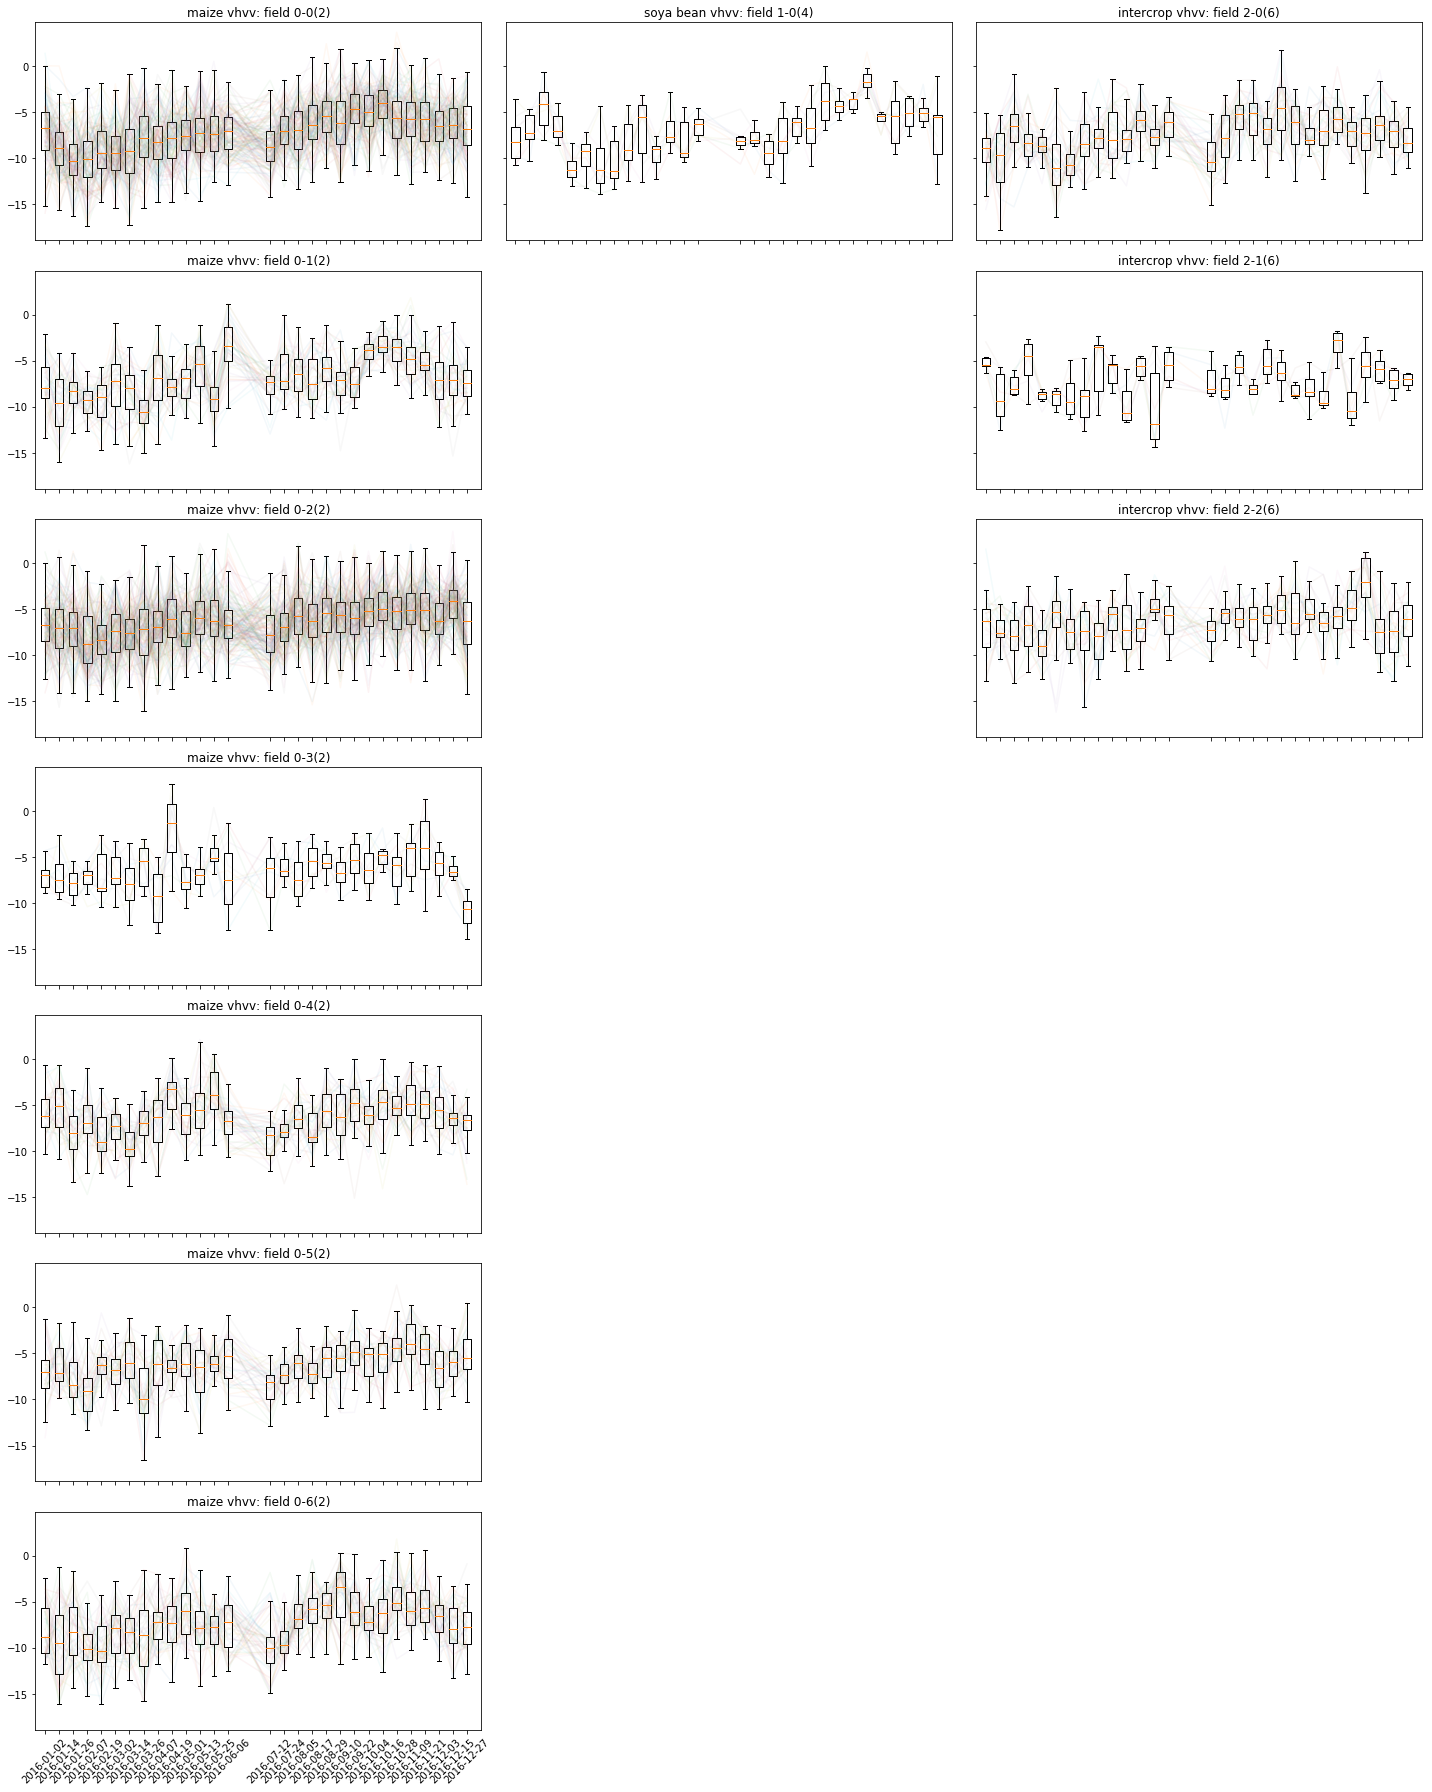

In [10]:
#####
index = s1indices.index("vhvv")
#####

from dates import datepositions
from plotting import fieldmask_colrowcount

datapos = index + len(s1bands)
ncol,nrow = fieldmask_colrowcount(fieldmasks)
fig,ax = matplotlib.pyplot.subplots(nrow,ncol,figsize=[20,25],sharex="all",sharey="all")
axs = ax.ravel(order='F')
idx = 0
delete = []
for i in range(ncol):
    for j in range(nrow):
        if j < fieldmasks[i][1]:
            data = []
            for k in range(len(s1items)):
                fm = numpy.copy(fieldmasks[i][0])
                data.append(list(s1data[k][datapos][fm == j+1]))
            axs[idx].boxplot(data,positions=datepositions(s1dates),widths=0.02,showfliers=False)
            axs[idx].plot(datepositions(s1dates),data,alpha=0.05)
            axs[idx].set_title(f'{groundlabels[crops[i]]["crop"]} {s1indices[index]}: field {i}-{j}({crops[i]})')
            axs[idx].set_xlim([-0.02,1.02])
            axs[idx].set_xticklabels(s1dates,rotation=45)
        else:
            delete.append(idx)
        idx = idx + 1
for i in range(len(delete)):
    fig.delaxes(axs[delete[i]])
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

The following visualises a chosen vegetation index derived from the Sentinel-2 observations, for each field, as a function of time. Here, options are normalised difference vegetation index ("ndvi"), red-edge chlorophyll index ("rdedci"), and normalised difference moisture index ("ndmi").

/home/ucfaab0/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


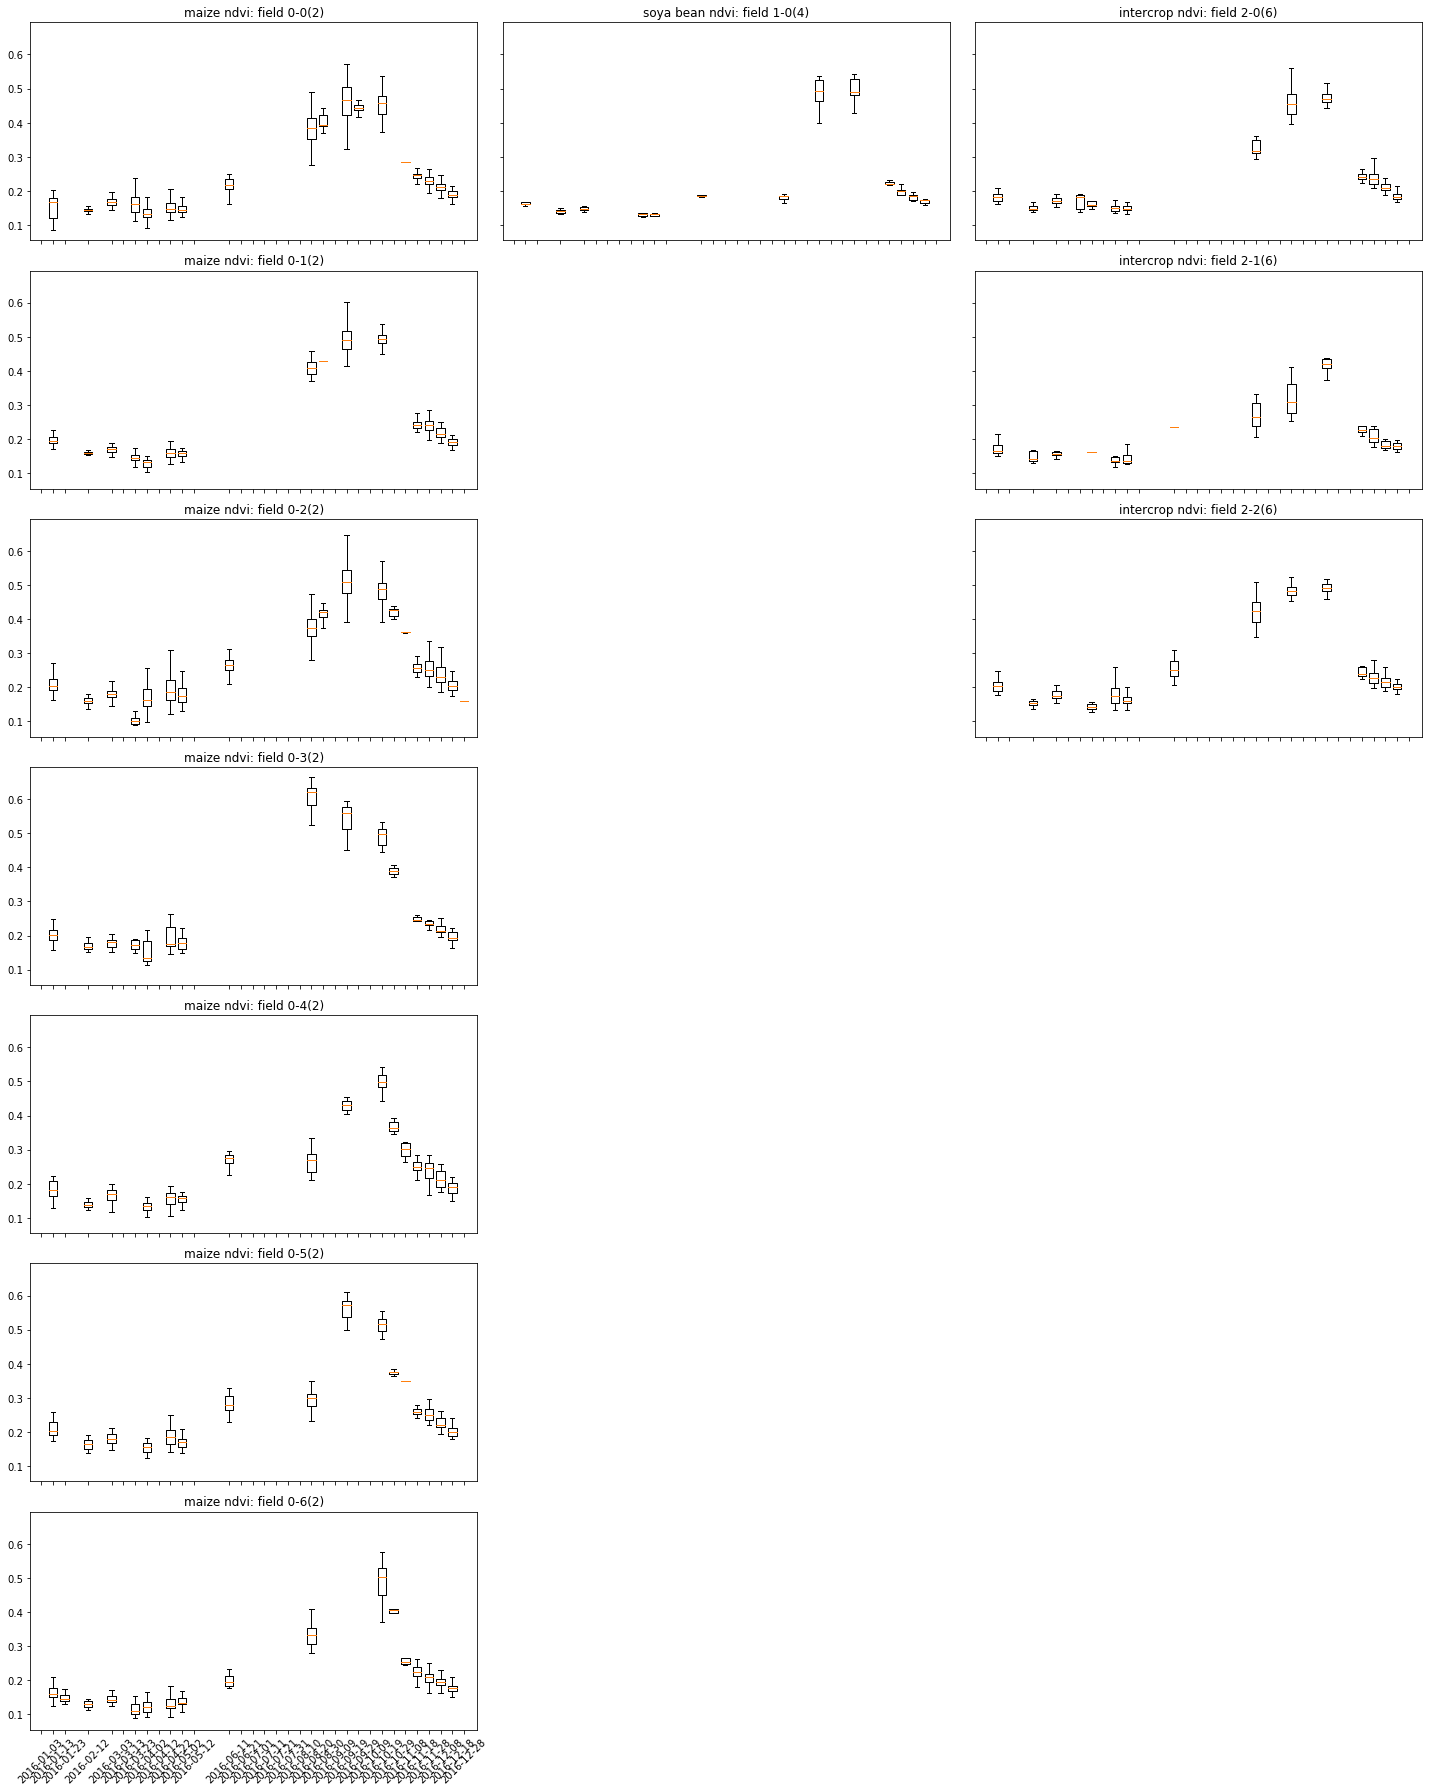

In [11]:
#####
index = s2indices.index("ndvi")
#####

datapos = index + len(s2bands)
ncol,nrow = fieldmask_colrowcount(fieldmasks)
fig,ax = matplotlib.pyplot.subplots(nrow,ncol,figsize=[20,25],sharex="all",sharey="all")
axs = ax.ravel(order='F')
idx = 0
delete = []
for i in range(ncol):
    for j in range(nrow):
        if j < fieldmasks[i][1]:
            data = []
            for k in range(len(s2items)):
                fm = numpy.copy(fieldmasks[i][0])
                cm = numpy.copy(s2cloudmasks[k])
                fm[cm != 0] = 0                
                data.append(list(s2data[k][datapos][fm == j+1]))
            axs[idx].boxplot(data,positions=datepositions(s2dates),widths=0.02,showfliers=False)
            axs[idx].set_title(f'{groundlabels[crops[i]]["crop"]} {s2indices[index]}: field {i}-{j}({crops[i]})')
            axs[idx].set_xlim([-0.02,1.02])
            axs[idx].set_xticklabels(s2dates,rotation=45)
        else:
            delete.append(idx)
        idx = idx + 1
for i in range(len(delete)):
    fig.delaxes(axs[delete[i]])
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

Finally, the Sentinel-2 spectra can be plotted for selected fields, as a function of wavelength, using the clear(ish) observations shown in the sequence of RGB composites. Fields are selected fields using the field IDs shown in the output from cell five (e.g., in the example here: 0-7(0), 1-1(4), 2-2(6); which correspond to the seventh maize, first soya bean and second intercrop fields, respectively).

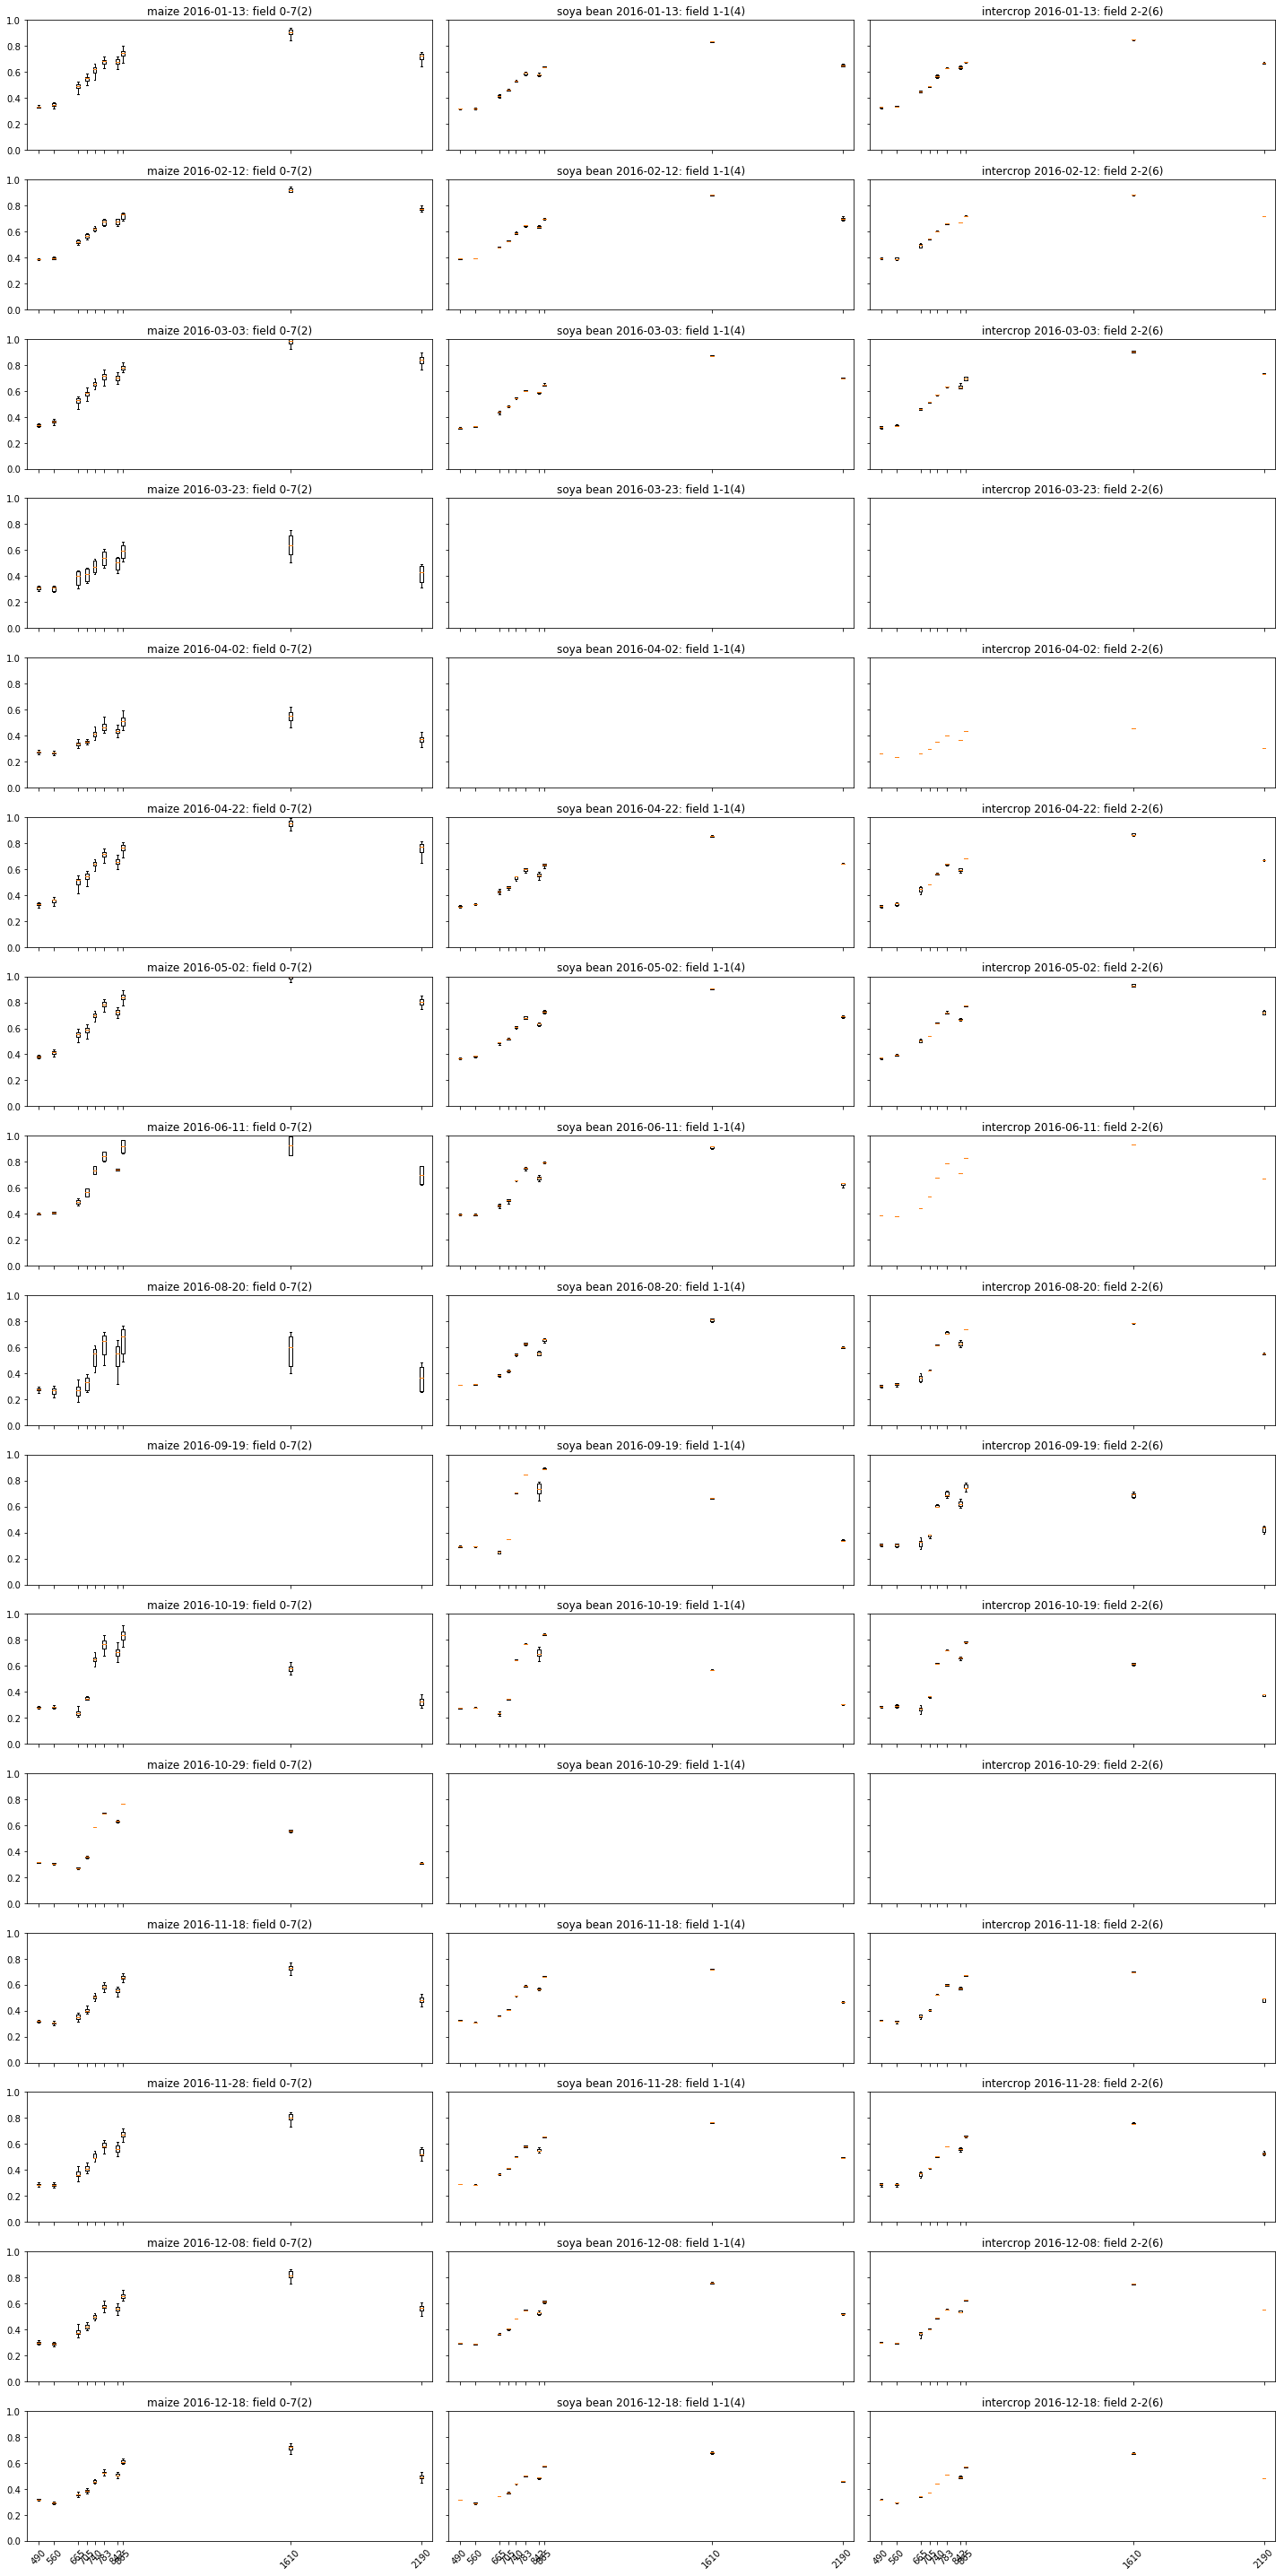

In [12]:
#####
fieldselection = [[0,7],[1,1],[2,2]]
#####

wavelengths = [i['wavelength'] for i in s2bands]

fig, ax = matplotlib.pyplot.subplots(len(s2cfdates),len(fieldselection),figsize=[20,40],sharex="all",sharey="all")
axs = ax.ravel()
idx = 0
for i in range(len(s2items)):
    if (s2dates[i] in s2cfdates) == True:    
        for j in range(len(fieldselection)):
            data = []
            fm = numpy.copy(fieldmasks[fieldselection[j][0]][0])
            cm = numpy.copy(s2cloudmasks[i])
            fm[cm != 0] = 0
            for k in range(len(s2bands)):
                data.append(list(s2data[i][k][fm == fieldselection[j][1]]))
            axs[idx].boxplot(data,positions=wavelengths,widths=15,showfliers=False)
            axs[idx].set_title(f'{groundlabels[crops[fieldselection[j][0]]]["crop"]} {s2dates[i]}: field {fieldselection[j][0]}-{fieldselection[j][1]}({crops[fieldselection[j][0]]})')
            axs[idx].set_xlim([min(wavelengths)-50,max(wavelengths)+50])
            axs[idx].set_ylim([0,1])
            axs[idx].set_xticklabels(wavelengths,rotation=45)
            idx = idx + 1
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()